In [2]:

!pip install torchvision

You should consider upgrading via the 'c:\users\pc\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.1+cu102  Device: cpu


In [5]:
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
''' 3. FashionMNIST 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                     train = False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [7]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


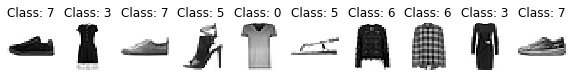

In [8]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [9]:
''' 6. AutoEncoder (AE) 모델 설계하기 '''
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
''' 7. Optimizer, Objective Function 설정하기 '''

model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [11]:
''' 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [12]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))
            
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)

    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.209500
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.026070
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.021709
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.018289
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.019566
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.019107
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.017756
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.015910
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.018428
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.015730

[EPOCH: 1], 	Test Loss: 0.0151


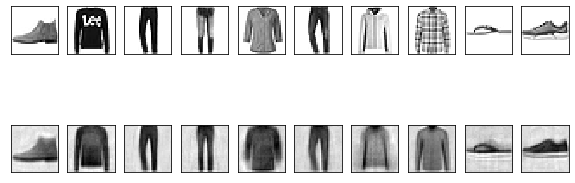

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.017791
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.012933
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.013861
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.014870
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.013782
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.013975
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.015480
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.015584
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.010608
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.014494

[EPOCH: 2], 	Test Loss: 0.0129


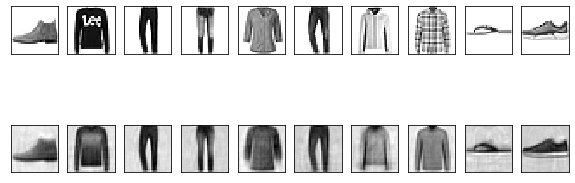

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.012810
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.014110
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.010185
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.011491
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.011818
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.012162
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.015404
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.011720
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.010931
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.010638

[EPOCH: 3], 	Test Loss: 0.0120


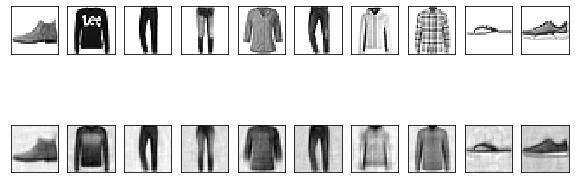

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.010915
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.014795
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.010404
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.009930
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.011077
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.010136
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.010642
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.010750
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.011340
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.012551

[EPOCH: 4], 	Test Loss: 0.0115


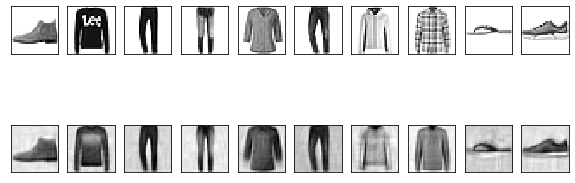

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.010041
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.009946
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.012546
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.010338
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.010648
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.012258
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.009359
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.009476
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.010316
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.010404

[EPOCH: 5], 	Test Loss: 0.0109


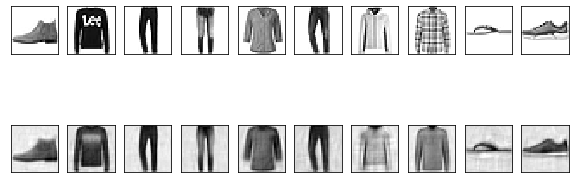

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.010356
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.012726
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.010679
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.011042
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.010268
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.009594
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.009111
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.011282
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.011089
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.009392

[EPOCH: 6], 	Test Loss: 0.0105


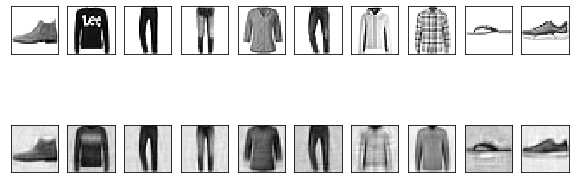

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.009712
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.011188
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.010986
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.009245
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.011886
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.008454
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.010062
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.009543
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.010276
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.012020

[EPOCH: 7], 	Test Loss: 0.0102


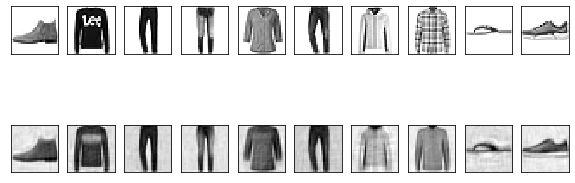

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.007712
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.009814
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.010263
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.011020
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.011255
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.009000
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.010220
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.010973
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.011835
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.009824

[EPOCH: 8], 	Test Loss: 0.0100


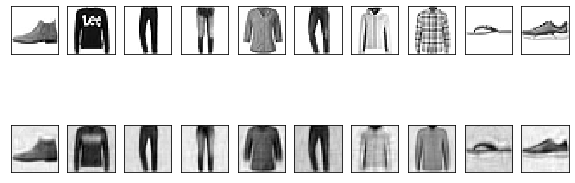

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.008894
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.010732
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.010981
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.008615
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.009980
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.010463
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.012775
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.009874
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.008259
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.010284

[EPOCH: 9], 	Test Loss: 0.0099


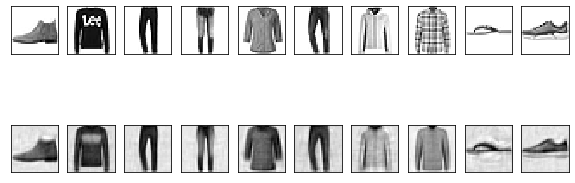

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.008283
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.009601
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.009874
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.008390
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.009748
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.010440
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.010192
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.008686
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.010374
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.009301

[EPOCH: 10], 	Test Loss: 0.0098


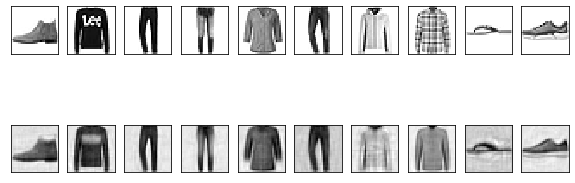

In [13]:
''' 10. AutoEncoder 학습 실행하며 Test set의 Reconstruction Error 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()